# Import Modules

In [1]:
import sys, os
sys.path.insert(1, "/usr/local/lib/python2.7/dist-packages/mxnet-0.7.0-py2.7.egg")
sys.path.insert(1, "/usr/local/lib/python2.7/dist-packages")

In [2]:
import h2o
import pandas
import mxnet as mx
import graphviz

In [3]:
project_path = "/gtc-2017"

# Connect or Start H2O

In [4]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  ----------------------
H2O cluster uptime:         1 hour 33 mins
H2O cluster version:        3.11.0.226
H2O cluster version age:    2 days
H2O cluster name:           root
H2O cluster total nodes:    1
H2O cluster free memory:    26.52 Gb
H2O cluster total cores:    20
H2O cluster allowed cores:  20
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
Python version:             2.7.12 final
--------------------------  ----------------------

# Import Data

Import data into H2O.

In [5]:
mnist_training = h2o.import_file(project_path+"/data/mnist-training.csv")
mnist_testing = h2o.import_file(project_path+"/data/mnist-testing.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


Change the "label" column to a factor (i.e. categorical feature).

In [6]:
mnist_training["label"] = mnist_training["label"].asfactor()
mnist_testing["label"] = mnist_testing["label"].asfactor()

# Explore Data

In [7]:
mnist_training.head()

uri label 
 
 
 /gtc-2017/data/mnist_png/training/6/6453.png 6 
 /gtc-2017/data/mnist_png/training/6/13970.png 6 
 /gtc-2017/data/mnist_png/training/6/21967.png 6 
 /gtc-2017/data/mnist_png/training/6/11277.png 6 
 /gtc-2017/data/mnist_png/training/6/27350.png 6 
 /gtc-2017/data/mnist_png/training/6/32119.png 6 
 /gtc-2017/data/mnist_png/training/6/44201.png 6 
 /gtc-2017/data/mnist_png/training/6/58770.png 6 
 /gtc-2017/data/mnist_png/training/6/39440.png 6 
 /gtc-2017/data/mnist_png/training/6/41988.png 6

Get the number of output classes from the data.

In [8]:
num_classes = mnist_training["label"].nlevels()[0]
print(num_classes)

10


# Test GPU Driver

In [9]:
!nvidia-smi

Mon May  8 20:30:46 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 378.13                 Driver Version: 378.13                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:02:00.0      On |                  N/A |
| 27%   35C    P8    11W / 180W |    710MiB /  8112MiB |     27%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Define Custom Network

We explicitly construct a LeNet network, allowing us to custom each layer properties (e.g. kernel, strides, filters).  The network is parameterized to accept different number of classes so that the output layer can be modified accordingly.

In [10]:
def lenet(num_classes):
    # Input layer
    data = mx.symbol.Variable("data")
    
    # Convolution layer 1
    conv1 = mx.symbol.Convolution(data=data, kernel=(5,5), num_filter=20)
    act1 = mx.symbol.Activation(data=conv1, act_type="tanh")
    pool1 = mx.symbol.Pooling(data=act1, pool_type="max", kernel=(2,2), stride=(2,2))
    
    # Convolution layer 2
    conv2 = mx.symbol.Convolution(data=data, kernel=(5,5), num_filter=50)
    act2 = mx.symbol.Activation(data=conv2, act_type="tanh")
    pool2 = mx.symbol.Pooling(data=act2, pool_type="max", kernel=(2,2), stride=(2,2))

    # Fully connected layer 1
    flatten = mx.symbol.Flatten(data=pool2)
    fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
    act3 = mx.symbol.Activation(data=fc1, act_type="tanh")
    
    # Fully connected layer 2
    fc2 = mx.symbol.FullyConnected(data=act3, num_hidden=500)
    out = mx.symbol.SoftmaxOutput(data=fc2, name="softmax")
    return out

Instantiate an instance of the network.

In [11]:
sym_my_lenet = lenet(num_classes)

We can visually view the network.

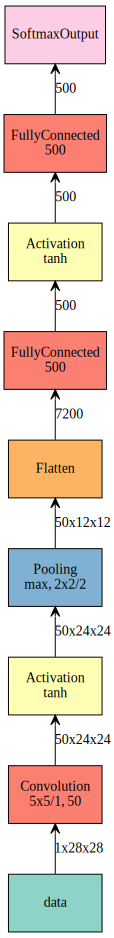

In [12]:
mx.viz.plot_network(sym_my_lenet, shape={"data": (1,1,28,28)}, node_attrs={"shape": "rect", "fixedsize": "false"})

The network is persistented so it can be passed to the Deep Water Estimator.

In [13]:
network_def_path = project_path+"/models/sym_my_lenet.json"
sym_my_lenet.save(network_def_path)

# Build Deep Water MXNet Model

In [14]:
from h2o.estimators.deepwater import H2ODeepWaterEstimator
model_mnist_mylenet_mx = H2ODeepWaterEstimator(epochs=80,
                                            network_definition_file=network_def_path,
                                            image_shape=[28,28],
                                            channels=1, model_id="model_mnist_mylenet_mx")
model_mnist_mylenet_mx.train(x=["uri"], y="label", training_frame=mnist_training, validation_frame=mnist_testing)

deepwater Model Build progress: |█████████████████████████████████████████| 100%


In [15]:
model_mnist_mylenet_mx.show()

Model Details
H2ODeepWaterEstimator :  Deep Water
Model Key:  model_mnist_mylenet_mx


ModelMetricsMultinomial: deepwater
** Reported on train data. **

MSE: 1.0
RMSE: 1.0
LogLoss: 34.5387763949
Mean Per-Class Error: 0.9
Confusion Matrix: vertical: actual; across: predicted



0    1    2    3    4    5    6    7     8    9    Error     Rate
---  ---  ---  ---  ---  ---  ---  ----  ---  ---  --------  -------------
0    0    0    0    0    0    0    970   0    0    1         970 / 970
0    0    0    0    0    0    0    1153  0    0    1         1,153 / 1,153
0    0    0    0    0    0    0    966   0    0    1         966 / 966
0    0    0    0    0    0    0    975   0    0    1         975 / 975
0    0    0    0    0    0    0    942   0    0    1         942 / 942
0    0    0    0    0    0    0    870   0    0    1         870 / 870
0    0    0    0    0    0    0    993   0    0    1         993 / 993
0    0    0    0    0    0    0    1062  0    0    0         0 / 1,062
0    0    0    0    0    0    0    993   0    0    1         993 / 993
0    0    0    0    0    0    0    1008  0    0    1         1,008 / 1,008
0    0    0    0    0    0    0    9932  0    0    0.893073  8,870 / 9,932

Top-10 Hit Ratios: 


k    hit_ratio
---  -----------
1    0.106927
2    0.201772
3    0.201772
4    0.201772
5    0.201772
6    0.201772
7    0.201772
8    0.201772
9    0.201772
10   1


ModelMetricsMultinomial: deepwater
** Reported on validation data. **

MSE: 1.0
RMSE: 1.0
LogLoss: 34.5387763949
Mean Per-Class Error: 0.9
Confusion Matrix: vertical: actual; across: predicted



0    1    2    3    4    5    6    7      8    9    Error    Rate
---  ---  ---  ---  ---  ---  ---  -----  ---  ---  -------  --------------
0    0    0    0    0    0    0    980    0    0    1        980 / 980
0    0    0    0    0    0    0    1135   0    0    1        1,135 / 1,135
0    0    0    0    0    0    0    1032   0    0    1        1,032 / 1,032
0    0    0    0    0    0    0    1010   0    0    1        1,010 / 1,010
0    0    0    0    0    0    0    982    0    0    1        982 / 982
0    0    0    0    0    0    0    892    0    0    1        892 / 892
0    0    0    0    0    0    0    958    0    0    1        958 / 958
0    0    0    0    0    0    0    1028   0    0    0        0 / 1,028
0    0    0    0    0    0    0    974    0    0    1        974 / 974
0    0    0    0    0    0    0    1009   0    0    1        1,009 / 1,009
0    0    0    0    0    0    0    10000  0    0    0.8972   8,972 / 10,000

Top-10 Hit Ratios: 


k    hit_ratio
---  -----------
1    0.1028
2    0.201
3    0.201
4    0.201
5    0.201
6    0.201
7    0.201
8    0.201
9    0.201
10   1

Scoring History: 


timestamp            duration    training_speed    epochs     iterations    samples    training_rmse    training_logloss    training_classification_error    validation_rmse    validation_logloss    validation_classification_error
--  -------------------  ----------  ----------------  ---------  ------------  ---------  ---------------  ------------------  -------------------------------  -----------------  --------------------  ---------------------------------
    2017-05-08 20:30:47  0.000 sec                     0          0             0          nan              nan                 nan                              nan                nan                   nan
    2017-05-08 20:30:47  1.155 sec   8126 obs/sec      0.0170667  1             1024       1                34.5388             0.893073                         1                  34.5388               0.8972
    2017-05-08 20:30:57  10.204 sec  13898 obs/sec     1.9968     117           119808     1                34.5388             0.893073                         1                  34.5388               0.8972
    2017-05-08 20:31:02  15.773 sec  14034 obs/sec     3.19147    187           191488     1                34.5388             0.893073                         1                  34.5388               0.8972
    2017-05-08 20:31:08  21.334 sec  13967 obs/sec     4.33493    254           260096     1                34.5388             0.893073                         1                  34.5388               0.8972
    2017-05-08 20:31:14  27.234 sec  13874 obs/sec     5.5296     324           331776     1                34.5388             0.893073                         1                  34.5388               0.8972
    2017-05-08 20:31:20  33.344 sec  13748 obs/sec     6.74133    395           404480     1                34.5388             0.893073                         1                  34.5388               0.8972
    2017-05-08 20:31:26  39.404 sec  13672 obs/sec     7.95307    466           477184     1                34.5388             0.893073                         1                  34.5388               0.8972
    2017-05-08 20:31:32  45.267 sec  13615 obs/sec     9.1136     534           546816     1                34.5388             0.893073                         1                  34.5388               0.8972
    2017-05-08 20:31:38  51.367 sec  13548 obs/sec     10.3083    604           618496     1                34.5388             0.893073                         1                  34.5388               0.8972
    2017-05-08 20:31:44  57.531 sec  13500 obs/sec     11.52      675           691200     1                34.5388             0.893073                         1                  34.5388               0.8972